# `20180225a` Playing with a probe

In [363]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import griddata
import math
from scipy.signal import decimate, convolve

import re
import glob, os

## Creating the set of acquisitions

In [364]:
AA = []
lbl = []
IDLine = []

for CSVFile in glob.glob("*.csv"):
    A = np.genfromtxt(CSVFile, delimiter=';').astype(int)[1:]
    tmp = [] 
    N = len(A)
    FF = CSVFile.split(".")[0].split("-")[-1]
    lbl.append(  CSVFile.split("-")[2] )
    f = int(re.sub('[^0-9]','', FF))
    #F = int(CSVFile.split(".")[0])

    if (A[4]) < 0b111:
        for i in range(len(A)/2-1):
            value = 256*(A[2*i+1]&0b11) + A[2*i+0] - 512
            IDLine.append((A[2*i+1]&0b11110000)/16) # Identify the # of the line
            tmp.append( value ) 
    else:
        for i in range(len(A)/2-1):
            value = 256*(A[2*i+1]&0b11) + A[2*i] - 512
            IDLine.append((A[2*i+1]&0b11110000)/16)
            #print A[2*i]&0b10000000,A[2*i+1]&0b10000000,
            tmp.append( value )
            #print A[2*i+1]
            #print A[i+1]-A[i] 
            
    AA.append(tmp)
    
    t = [ 1.0*x/f for x in range(len(tmp))]



## Setting the beginning of the lines

1375 189


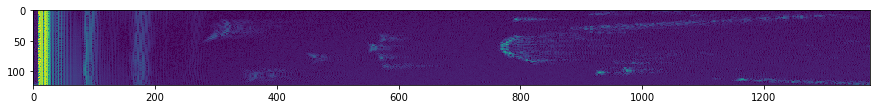

In [378]:
StartLine = []
av = []
for k in range(len(IDLine)-1):
    if IDLine[k] <> IDLine[k+1]:
        StartLine.append(k)
for k in range( len(StartLine) -1) :
    av.append(StartLine[k+1]-StartLine[k])
l = max(av)
n = len(StartLine)
print l,n
Offset= 45
IMG = np.zeros((n-1-65,l))
for k in range(n-1-65):
    for j in range(l):
        IMG[k,j] = tmp[StartLine[k+65]+j]
plt.figure(figsize=(15,5))
plt.imshow(np.sqrt(np.abs(IMG)))
plt.show()

In [368]:
def CreateSC(RawImgData):
    LenLinesC = np.shape(RawImgData)[1]
    NbLinesC = np.shape(RawImgData)[0]
    SC = np.zeros((LenLinesC,LenLinesC))
    SC += 1
    maxAngle = 60.0
    step = maxAngle/(NbLinesC+1)
    CosAngle = math.cos(math.radians(30))
    Limit = LenLinesC*CosAngle

    points = []
    values = []

    for i in range(LenLinesC):
        for j in range(LenLinesC):
            if (  (j > LenLinesC/2 + i/(2*CosAngle)) or  (j < LenLinesC/2 - i/(2*CosAngle)) ):
                SC[i][j] = 0
                points.append([i,j])
                values.append(0)
            if (  (i > Limit) ):
                if ( (i**2 + (j-LenLinesC/2) ** 2) > LenLinesC**2):
                    SC[i][j] = 0 
                    points.append([i,j])
                    values.append(0)
    for i in range(NbLinesC):
        PointAngle = i*step-30
        COS = math.cos(math.radians(PointAngle))
        SIN = math.sin(math.radians(PointAngle))
        for j in range(LenLinesC):

            X = (int)( j*COS)
            Y = (int)(LenLinesC/2 - j*SIN)
            SC[X][Y] = RawImgData[i][j]
            points.append([X,Y])
            values.append(RawImgData[i][j])

    values = np.array(values,dtype=np.int)
    
    return SC,values,points,LenLinesC

In [369]:
Debug = 0
SmallImg = IMG

## Extracting the enveloppe of the signals / acquisitions

In [379]:
Fech = 10
NbLine = 70
LineLength =  len(IMG[NbLine]) 
FFT = np.fft.fft(IMG[NbLine])
FFTClean = np.fft.fft(IMG[NbLine])
for k in range(LineLength/2+1):
    if k < 220 or k > 420:
        FFTClean[k] = 0
        FFTClean[-k] = 0

F = np.real(np.fft.ifft(FFTClean))
IMGClean = np.asarray(np.abs(signal.hilbert(F)))
IMGCleanNoFFT = np.asarray(np.abs(signal.hilbert(IMG[NbLine])))

fx = [ 1.0*Fech*x/LineLength for x in range(LineLength)]
tx = [ 1.0*x/Fech for x in range(LineLength)]

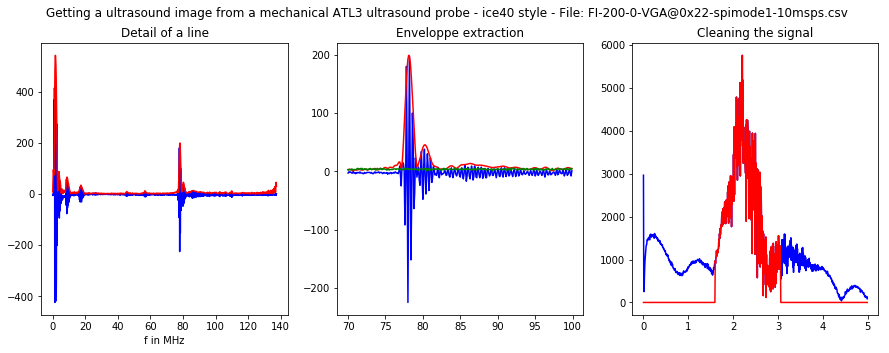

In [407]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(tx,IMG[NbLine],"b")
ax1.plot(tx,IMGClean,"r")
ax1.set_title("Detail of a line")
ax1.set_xlabel("Time in uS")
ax2.plot(tx[700:1000],IMG[NbLine][700:1000],"b")
ax2.plot(tx[700:1000],IMGClean[700:1000],"r")
ax2.plot(tx[700:1000],IMGCleanNoFFT[700:1000],"g")
ax2.set_title("Enveloppe extraction")
ax1.set_xlabel("Time in uS")
ax3.plot(fx[0:LineLength/2],np.abs(FFT)[0:LineLength/2],"b") # fx[0:LineLength/2],
ax3.plot(fx[0:LineLength/2],np.abs(FFTClean)[0:LineLength/2],"r") 
ax3.set_title("Cleaning the signal")
ax1.set_xlabel("f in MHz")

plt.suptitle('Getting a ultrasound image from a mechanical ATL3 ultrasound probe - ice40 style - File: '+CSVFile)
plt.savefig('line'+str(NbLine)+".jpg", bbox_inches='tight')
plt.show()

### Clipping the signal

In [401]:
Hb = []
for i in range(123):
    IMGCleanNoFFT = np.asarray(np.abs(signal.hilbert(IMG[i]))) 
    Hb.append(IMGCleanNoFFT)
print np.shape(Hb)
HB = np.concatenate((np.zeros((123,650)),Hb), axis=1)
HBT = HB[:,0:-450]
HB=HBT

(123, 1375)


In [402]:
HBB = decimate(HB,2)

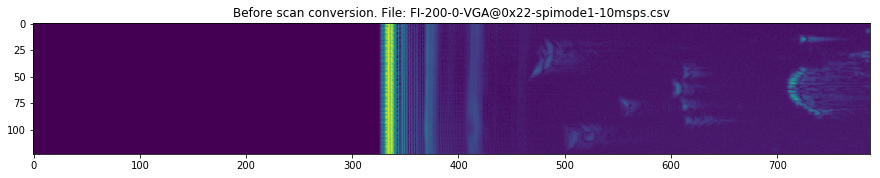

In [409]:
plt.figure(figsize=(15,5))
plt.imshow(np.sqrt(np.abs(HBB)))
plt.title("Before scan conversion. File: "+CSVFile)
plt.savefig("raw.jpg", bbox_inches='tight')
plt.show()

In [404]:
if not(Debug):
    SCH,valuesH,pointsH,LenLinesCH = CreateSC(np.sqrt(np.abs(HBB)))
    grid_xH, grid_yH = np.mgrid[0:LenLinesCH:1, 0:LenLinesCH:1]
    grid_z1H = griddata(pointsH, valuesH, (grid_xH, grid_yH), method='linear')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in power


788


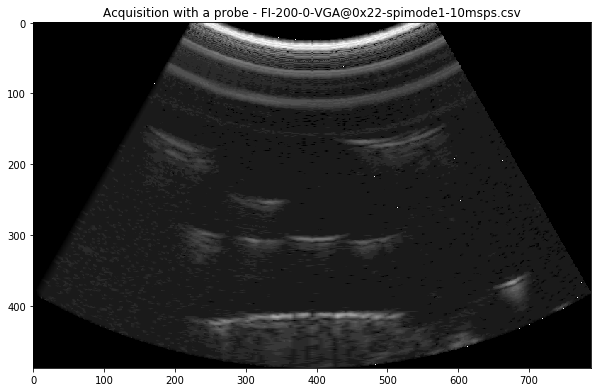

In [410]:
print len((grid_z1H**0.7))
if not(Debug):
    plt.figure(figsize=(10,10))
    plt.title("Acquisition with a probe - "+CSVFile)
    plt.imshow((grid_z1H**0.7)[300:788,0:788],cmap=plt.get_cmap('gray'))  
    plt.savefig("probe.jpg", bbox_inches='tight')
    plt.show()